In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%run Feature-Engineering.ipynb

Convert all data into INT64
Drop some of the data
  Removing 55463 NaN values from 30 columns


In [2]:
# use feature importance for feature selection, with fix for xgboost 1.0.2
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel

In [4]:
# load data
length_df = pecarn_df.shape[1] - 1
X = pecarn_df.iloc[:,0:length_df].astype('int64')  #independent columns
Y = pecarn_df.iloc[:,-1].astype('int64')    #target column
Y

PatNum
1        0
2        0
3        0
4        0
5        0
        ..
43395    0
43396    0
43397    0
43398    0
43399    0
Name: PosIntFinal, Length: 43399, dtype: int64

In [6]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), Y.to_numpy(), test_size=0.33, random_state=7)

array([[15, 11,  1, ...,  0,  0,  0],
       [15,  1,  0, ...,  0,  0,  0],
       [15, 12,  0, ...,  0,  0,  0],
       ...,
       [15, 11,  0, ...,  0,  0,  0],
       [15,  5,  0, ...,  0,  0,  0],
       [15,  1,  0, ...,  0,  0,  0]], dtype=int64)

In [7]:
# define custom class to fix bug in xgboost 1.0.2
class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None

# fit model on all training data
model = MyXGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
thresholds[1]

Accuracy: 98.59%


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.0008537 , 0.00099266,
       0.00119707, 0.00148485, 0.00150307, 0.00163283, 0.00166835,
       0.00214566, 0.00231107, 0.00233927, 0.0024746 , 0.00262446,
       0.0029911 , 0.00301861, 0.0032854 , 0.00346085, 0.00354977,
       0.00400134, 0.00402135, 0.00410262, 0.00411993, 0.00414

In [10]:
thresholds = thresholds[thresholds != 0.0]
thresholds = list(dict.fromkeys(thresholds))
thresholds

array([0.0008537 , 0.00099266, 0.00119707, 0.00148485, 0.00150307,
       0.00163283, 0.00166835, 0.00214566, 0.00231107, 0.00233927,
       0.0024746 , 0.00262446, 0.0029911 , 0.00301861, 0.0032854 ,
       0.00346085, 0.00354977, 0.00400134, 0.00402135, 0.00410262,
       0.00411993, 0.00414978, 0.00426547, 0.00429489, 0.00434938,
       0.00440116, 0.00446475, 0.00450134, 0.00450974, 0.00451722,
       0.00451962, 0.00476478, 0.0047813 , 0.0048825 , 0.00492133,
       0.00492739, 0.00499126, 0.00499768, 0.00505966, 0.0050748 ,
       0.00516965, 0.0052022 , 0.00520525, 0.00521977, 0.00522594,
       0.00527403, 0.00531776, 0.00539166, 0.00543516, 0.00546676,
       0.00568965, 0.00572488, 0.00577208, 0.00578258, 0.0057899 ,
       0.00584094, 0.00588877, 0.00589504, 0.00595457, 0.00598347,
       0.00599953, 0.00602243, 0.00602631, 0.00602914, 0.00603712,
       0.0060681 , 0.00611595, 0.0061662 , 0.00619156, 0.00621215,
       0.00621534, 0.00621647, 0.00625991, 0.00634852, 0.00638

In [11]:
index = 0
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    predictions = selection_model.predict(select_X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    print("index=%d, Thresh=%.3f, n=%d, Accuracy: %.2f%%, F1 score: %.2f" % (index,thresh, select_X_train.shape[1], accuracy*100.0, f1))
    index = index + 1

index=0, Thresh=0.001, n=131, Accuracy: 98.59%, F1 score: 0.45
index=1, Thresh=0.001, n=130, Accuracy: 98.54%, F1 score: 0.42
index=2, Thresh=0.001, n=129, Accuracy: 98.58%, F1 score: 0.45
index=3, Thresh=0.001, n=128, Accuracy: 98.58%, F1 score: 0.46
index=4, Thresh=0.002, n=127, Accuracy: 98.58%, F1 score: 0.45
index=5, Thresh=0.002, n=126, Accuracy: 98.58%, F1 score: 0.45
index=6, Thresh=0.002, n=125, Accuracy: 98.59%, F1 score: 0.44
index=7, Thresh=0.002, n=124, Accuracy: 98.57%, F1 score: 0.45
index=8, Thresh=0.002, n=123, Accuracy: 98.57%, F1 score: 0.45
index=9, Thresh=0.002, n=122, Accuracy: 98.54%, F1 score: 0.44
index=10, Thresh=0.002, n=121, Accuracy: 98.55%, F1 score: 0.44
index=11, Thresh=0.003, n=120, Accuracy: 98.55%, F1 score: 0.44
index=12, Thresh=0.003, n=119, Accuracy: 98.57%, F1 score: 0.45
index=13, Thresh=0.003, n=118, Accuracy: 98.58%, F1 score: 0.46
index=14, Thresh=0.003, n=117, Accuracy: 98.58%, F1 score: 0.45
index=15, Thresh=0.003, n=116, Accuracy: 98.60%, F

In [12]:
# Manually choosing Number and Threshold
total_number = 21
thresh = thresholds[108]

# select features using threshold
selection = SelectFromModel(model, threshold=thresh, prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = XGBClassifier(scale_pos_weight=1)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_test = selection.transform(X_test)
predictions = selection_model.predict(select_X_test)
accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
print("Thresh=%.3f, n=%d, Accuracy: %.2f%%, F1 score: %.2f" % (thresh, select_X_train.shape[1], accuracy*100.0, f1))

Thresh=0.009, n=23, Accuracy: 98.53%, F1 score: 0.44


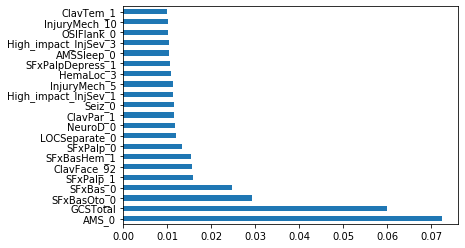

In [13]:
import matplotlib.pyplot as plt

X = pecarn_df.iloc[:,0:length_df].astype('int64')  #independent columns
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(total_number).plot(kind='barh')
plt.show()

In [14]:
features = pd.DataFrame(model.feature_importances_, columns=['Importance'], index=X.columns)
features['Feature'] = features.index
selected_features = features[features.Importance >= thresh]
selected_features.sort_values(by='Importance', ascending=False)

,Importance,Feature
AMS_0,0.072505,AMS_0
GCSTotal,0.060003,GCSTotal
SFxBasOto_0,0.029231,SFxBasOto_0
SFxBas_0,0.024678,SFxBas_0
SFxPalp_1,0.015744,SFxPalp_1
ClavFace_92,0.015615,ClavFace_92
SFxBasHem_1,0.015402,SFxBasHem_1
SFxPalp_0,0.013323,SFxPalp_0
LOCSeparate_0,0.011944,LOCSeparate_0
NeuroD_0,0.011670,NeuroD_0
